# MLP - Top model according to the SCPM of -3.27 and dominance count of 4

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

2024-11-09 23:37:35.222079: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 23:37:35.224877: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 23:37:35.287214: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 23:37:35.288956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 23:37:36.305690: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
class MLP(RegressorMixin):
    def __init__(
        self,
        callbacks=None,
        validation_split=0.0,
    ):
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0
        self.callbacks = callbacks
        self.validation_split = validation_split

    def fit(self, X=None, y=None):
        self.model.build(X.shape)
        self.load_pretrained_weights()
        self.history = self.model.fit(
            X,
            y,
            batch_size=self.batch_size,
            epochs=self.epochs,
            verbose=self.verbose,
            callbacks=self.callbacks,
            validation_split=self.validation_split,
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = tf.keras.Sequential()

        # First Dense layer with Batch Normalization
        model.add(tf.keras.layers.Dense(units=256, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())  # Add BatchNormalization
        model.add(tf.keras.layers.Dropout(rate=0.25))
        # Subsequent Dense layers with Batch Normalization
        model.add(tf.keras.layers.Dense(units=128, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units=64, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=32, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(units=16, activation="selu"))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=0.10))
        model.add(tf.keras.layers.Dense(units=1))

        model.compile(
            optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )

        return model

    def load_pretrained_weights(self, freeze_layers=0):
        # Load global weights
        self.model.load_weights(full_path)

        # Freeze layers
        for layer in self.model.layers[:freeze_layers]:
            layer.trainable = False
        if freeze_layers > 0:
            self.model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                loss="mse",
                metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
            )
        return

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
REPEAT = 0

<IPython.core.display.Javascript object>

In [5]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [6]:
weights_path = "../../../../models/global_models/204/mlp/f/pre_training/"
model_name = "mlp_full_vars_weights.h5"
full_path = os.path.join(weights_path, model_name)

<IPython.core.display.Javascript object>

In [7]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [8]:
results_to_save = []

results_dict = {
    "Category": "Global Model",
    "Company": "204",
    "Plant": "F",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "MLP",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [9]:
df = pd.read_csv("../../../../data/processed/204/f.csv")

<IPython.core.display.Javascript object>

## Defining Features

In [10]:
df_copy = df.copy().drop(["Cement_Type"], axis=1)

<IPython.core.display.Javascript object>

In [11]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

# 1. Multi Layer Perceptron

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [12]:
set_seeds()
start = time.time()

repeats = 3
n_splits = 5
train_size = 0.8
scores_final = None
results_repeats = {}

for repeat in range(repeats):
    pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("transformer", StandardScaler()),
            ("estimator", MLP()),
        ]
    )
    cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
    scores = cross_validate(
        pipeline,
        x,
        y,
        scoring=METRICS,
        cv=cv,
        # n_jobs=None,
        return_train_score=True,
        return_estimator=True,
        return_indices=True,
    )
    results_repeats[repeat] = scores

    if scores_final is None:
        scores_final = {key: [] for key, _ in scores.items()}

    for key, value in scores.items():
        scores_final[key] += [value]


print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores_final, METRICS, METRICS_DICT)

scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 3, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

2024-11-09 23:37:38.397346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-09 23:37:38.397416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: inspirada
2024-11-09 23:37:38.397430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: inspirada
2024-11-09 23:37:38.397667: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-11-09 23:37:38.397738: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2024-11-09 23:37:38.397750: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.251 (0.055)
MAE: -0.981 (0.049)
MAPE: -0.024 (0.001)
R2: 0.967 (0.003)


******
[TEST]
******
RMSE: -1.415 (0.224)
MAE: -1.113 (0.201)
MAPE: -0.027 (0.005)
R2: 0.955 (0.014)


Minutes Elapsed:  9.850015040238699


<IPython.core.display.Javascript object>

In [13]:
def get_predictions_df(scores):
    df_pred = pd.DataFrame()
    df_pred["DATE"] = dates.copy()
    df_pred["CS28"] = y.copy()
    df_pred["CS28_PRED"] = np.nan
    df_pred["SET"] = ""
    df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
    df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

    for idx, pipeline in enumerate(scores["estimator"]):
        index_train = scores["indices"]["train"][idx]
        index_test = scores["indices"]["test"][idx]
        index_preds = np.concatenate([index_train, index_test])

        # results = scores["estimator"][0].predict(x.loc[index_preds])
        results = pipeline.predict(x.loc[index_preds])
        df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
        df_pred.loc[index_train, "SET"] = "TRAIN"
        df_pred.loc[index_test, "SET"] = "TEST"
    df_pred = df_pred.dropna()
    return df_pred

<IPython.core.display.Javascript object>

In [14]:
dfs = []
for repeat in range(repeats):
    scores = results_repeats[repeat]
    df_pred = get_predictions_df(scores)
    df_pred["REPEAT"] = repeat
    dfs.append(df_pred)

df_pred = pd.concat(dfs)

<IPython.core.display.Javascript object>

In [15]:
df_pred = dfs[0]
df_pred["CS28_PRED"] = (
    dfs[0]["CS28_PRED"] + dfs[1]["CS28_PRED"] + dfs[2]["CS28_PRED"]
) / 3

<IPython.core.display.Javascript object>

In [16]:
# df_copy_merge = (
#     df_copy.reset_index(drop=True)
#     .merge(
#         df_pred.reset_index(drop=True), left_index=True, right_index=True, how="inner"
#     )
#     .drop("REPEAT", axis=1)
# )

# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# df_copy_merge.to_excel("global_model_mlp_btsscv_203_c.xlsx", index=False)
# df_copy_merge.to_csv("global_model_mlp_btsscv_203_c.csv", index=False)

<IPython.core.display.Javascript object>

In [17]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-02,36.3,37.523430,TRAIN
1,2020-01-04,52.2,49.153214,TRAIN
2,2020-01-04,48.7,49.388523,TRAIN
3,2020-01-05,33.0,36.413185,TRAIN
4,2020-01-05,33.8,36.615623,TRAIN
...,...,...,...,...
2505,2023-06-28,48.1,48.674988,TEST
2506,2023-06-28,50.1,49.204197,TEST
2507,2023-06-28,48.5,48.342552,TEST
2508,2023-06-28,36.5,36.983776,TEST


<IPython.core.display.Javascript object>

In [18]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

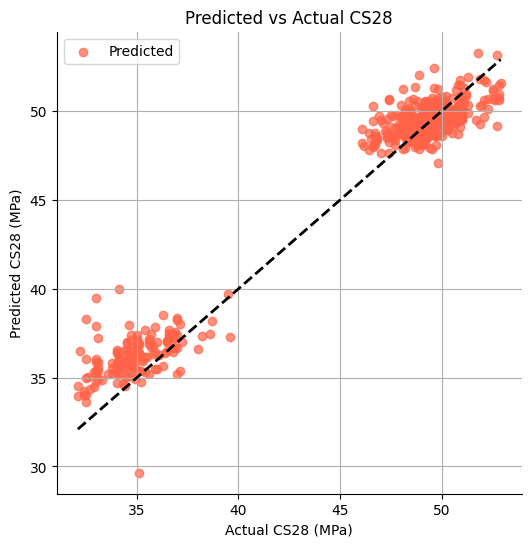

<IPython.core.display.Javascript object>

In [19]:
# Filter to only include the test set
test_data = df_pred[df_pred["SET"] == "TEST"]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_204_f_global_cm_p_cs_btiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [20]:
df["Cement_Type"].value_counts()

Cement_Type
CPV ARI       942
CPV ARI RS    751
CPIV 32       372
CP II E 32    253
CPII F 32     196
Name: count, dtype: int64

<IPython.core.display.Javascript object>

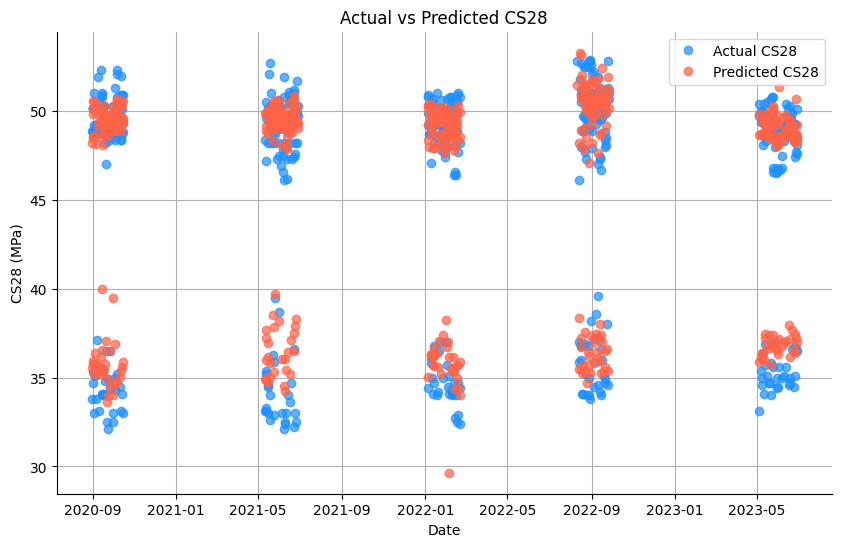

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_204_f_global_cm_p_cs_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


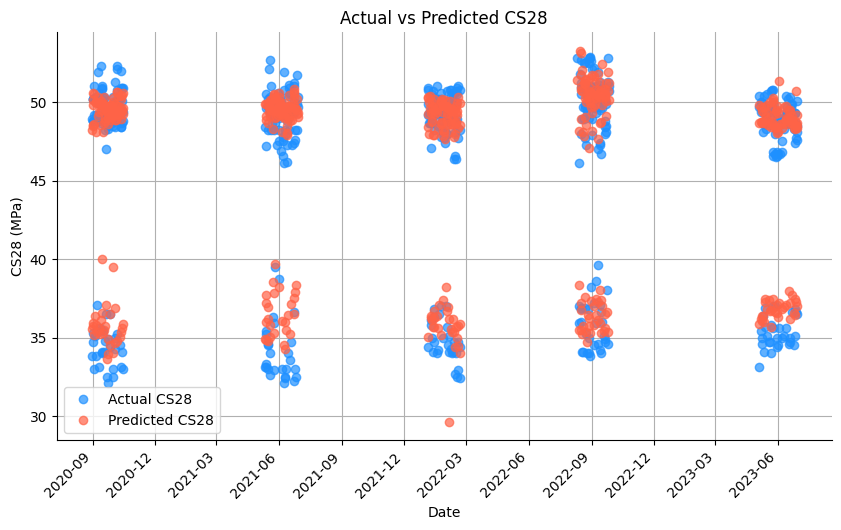

<IPython.core.display.Javascript object>

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_204_f_global_cm_p_cs_btiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [23]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm

<IPython.core.display.Javascript object>

In [24]:
perm_importances = []

for repeat in range(repeats):
    scores = results_repeats[repeat]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_index = indices["test"]
    estimators = scores["estimator"]
    indices = scores["indices"]
    test_indexes = indices["test"]

    for i, (pipeline, test_idx) in tqdm(enumerate(zip(estimators, test_indexes))):
        result = permutation_importance(
            pipeline,
            x.iloc[test_idx],
            y[test_idx],
            n_repeats=10,
            random_state=SEED,
            n_jobs=1,
            scoring="r2",
        )
        perm_importances.append(result.importances_mean)

5it [01:05, 13.19s/it]
5it [01:05, 13.06s/it]
5it [01:03, 12.70s/it]


<IPython.core.display.Javascript object>

In [25]:
# Average importances across folds
mean_importances = np.mean(perm_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(perm_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [26]:
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [27]:
rename_dict = {
    "K2O": r"$\mathrm{K_2O}$",
    "Free CaO": r"Free $\mathrm{CaO}$",
    "Total C2S": r"Total $\mathrm{C_2S}$",
    "Na2O": r"$\mathrm{Na_2O}$",
    "CaO": r"$\mathrm{CaO}$",
    "SiO2": r"$\mathrm{SiO_2}$",
    "MgO": r"$\mathrm{MgO}$",
    "Fe2O3": r"$\mathrm{Fe_2O_3}$",
    "Al2O3": r"$\mathrm{Al_2O_3}$",
    "Total C3S": r"Total $\mathrm{C_3S}$",
    "C3A": r"$\mathrm{C_3A}$",
    "C4AF": r"$\mathrm{C_4AF}$",
    "LOI": "LOI",
    "SO3": r"$\mathrm{SO_3}$",
    "Insoluble Residue": "IR",
    "Loss on Ignition": "LOI",
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

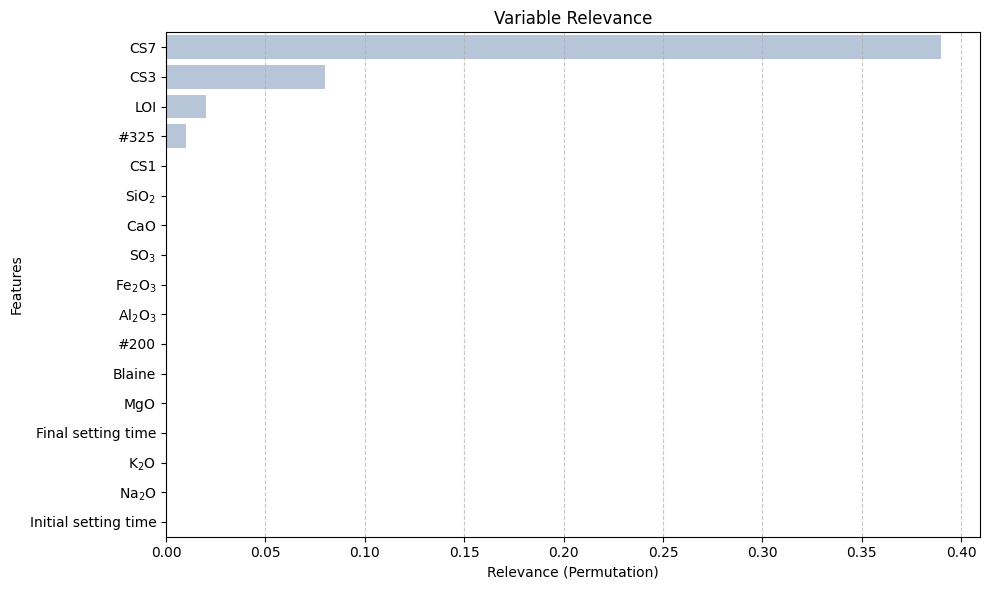

<IPython.core.display.Javascript object>

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Relevance")
plt.xlabel("Relevance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


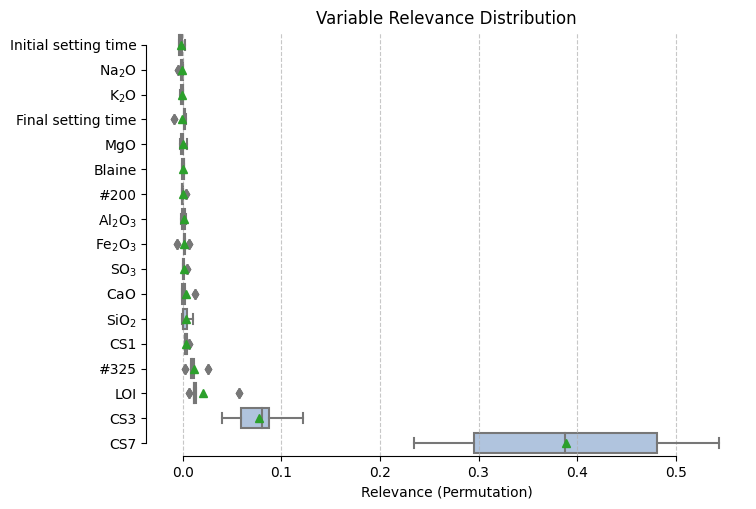

<IPython.core.display.Javascript object>

In [29]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]


# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "Loss on Ignition": "LOI",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_204_f_global_cm_p_cs_btiss_mlp_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [30]:
df_importances = perm_importances_df

<IPython.core.display.Javascript object>

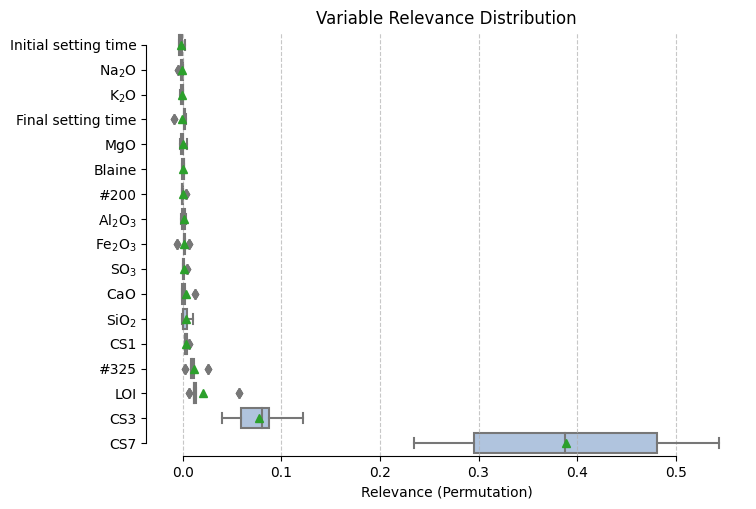

<IPython.core.display.Javascript object>

In [31]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig("ecics_204_f_global_cm_p_cs_btiss_mlp_scpm_best_dist_var_perm_relevance.png", dpi=300, bbox_inches='tight')
plt.show()


In [32]:
df_importances

,Initial setting time,$\mathrm{Na_2O}$,$\mathrm{K_2O}$,Final setting time,$\mathrm{MgO}$,Blaine,#200,$\mathrm{Al_2O_3}$,$\mathrm{Fe_2O_3}$,$\mathrm{SO_3}$,$\mathrm{CaO}$,$\mathrm{SiO_2}$,CS1,#325,LOI,CS3,CS7
0,-0.004288,-0.000175,0.000340,0.000957,0.000386,0.001135,0.003408,-0.000565,-0.005491,0.004704,0.002123,-0.000348,0.002137,0.025792,0.011613,0.079985,0.387335
1,-0.003881,-0.004688,-0.001873,-0.009184,-0.002612,0.000843,-0.000638,0.003427,0.002183,0.000541,0.001053,0.000543,0.002340,0.009280,0.013433,0.059154,0.234697
2,-0.003310,-0.001500,0.000693,0.001961,0.004389,-0.000737,0.000038,0.001429,0.001358,-0.000245,0.012151,0.000259,0.006536,0.011463,0.011590,0.087188,0.481373
3,-0.001006,0.000599,0.000335,0.000767,0.000690,0.000965,-0.000722,0.002025,0.006020,0.001539,-0.000950,0.004592,0.003831,0.007968,0.005975,0.122288,0.544113
4,0.002382,-0.000560,-0.002734,0.003130,-0.001916,-0.001071,-0.000373,-0.001487,0.001457,0.000547,-0.000396,0.010325,0.003749,0.002276,0.057328,0.040224,0.294961
5,-0.004288,-0.000175,0.000340,0.000957,0.000386,0.001135,0.003408,-0.000565,-0.005491,0.004704,0.002123,-0.000348,0.002137,0.025792,0.011613,0.079985,0.387335
6,-0.003881,-0.004688,-0.001873,-0.009184,-0.002612,0.000843,-0.000638,0.003427,0.002183,0.000541,0.001053,0.000543,0.002340,0.009280,0.013433,0.059154,0.234697
7,-0.003310,-0.001500,0.000693,0.001961,0.004389,-0.000737,0.000038,0.001429,0.001358,-0.000245,0.012151,0.000259,0.006536,0.011463,0.011590,0.087188,0.481373
8,-0.001006,0.000599,0.000335,0.000767,0.000690,0.000965,-0.000722,0.002025,0.006020,0.001539,-0.000950,0.004592,0.003831,0.007968,0.005975,0.122288,0.544113
9,0.002382,-0.000560,-0.002734,0.003130,-0.001916,-0.001071,-0.000373,-0.001487,0.001457,0.000547,-0.000396,0.010325,0.003749,0.002276,0.057328,0.040224,0.294961


<IPython.core.display.Javascript object>

In [33]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
Initial setting time,15.0,-0.002021,0.002564,-0.004288,-0.003881,-0.003310,-0.001006,0.002382
$\mathrm{Na_2O}$,15.0,-0.001265,0.001905,-0.004688,-0.001500,-0.000560,-0.000175,0.000599
$\mathrm{K_2O}$,15.0,-0.000648,0.001434,-0.002734,-0.001873,0.000335,0.000340,0.000693
Final setting time,15.0,-0.000474,0.004591,-0.009184,0.000767,0.000957,0.001961,0.003130
$\mathrm{MgO}$,15.0,0.000187,0.002544,-0.002612,-0.001916,0.000386,0.000690,0.004389
Blaine,15.0,0.000227,0.000967,-0.001071,-0.000737,0.000843,0.000965,0.001135
#200,15.0,0.000343,0.001610,-0.000722,-0.000638,-0.000373,0.000038,0.003408
$\mathrm{Al_2O_3}$,15.0,0.000966,0.001837,-0.001487,-0.000565,0.001429,0.002025,0.003427
$\mathrm{Fe_2O_3}$,15.0,0.001105,0.003846,-0.005491,0.001358,0.001457,0.002183,0.006020
$\mathrm{SO_3}$,15.0,0.001417,0.001799,-0.000245,0.000541,0.000547,0.001539,0.004704


<IPython.core.display.Javascript object>